In [1]:
import os 
import shutil
import random
import glob

In [2]:
# 1. Import required modules
from anomalib.data import MVTecAD
from anomalib.deploy import ExportType
from anomalib.engine import Engine
from anomalib.models import Patchcore
from anomalib.data import Folder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

/Users/zideng/mamba/envs/ml/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zideng/mamba/envs/ml/lib/python3.13/site-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


In [ ]:
!mkdir spider_test
!mkdir spider_test/normal
!mkdir spider_test/abnormal

# Set random seed for reproducible results
random.seed(42)

# Collect all image files first
normal_files = []
abnormal_files = []

for root, dirs, files in os.walk("/Users/zideng/Work/LDAWT/examples/black_widows_6_17"):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            full_path = os.path.join(root, file)
            if "Latrodectus_hesperus" in root:
                abnormal_files.append(full_path)
            else:
                normal_files.append(full_path)

# Randomly sample the desired number of files
normal_sample = random.sample(normal_files, min(200, len(normal_files)))
abnormal_sample = random.sample(abnormal_files, min(100, len(abnormal_files)))

# Copy the sampled files
for file_path in normal_sample:
    filename = os.path.basename(file_path)
    shutil.copy(file_path, os.path.join("spider_test/normal", filename))

for file_path in abnormal_sample:
    filename = os.path.basename(file_path)
    shutil.copy(file_path, os.path.join("spider_test/abnormal", filename))

print(f"Copied {len(normal_sample)} files to normal folder")
print(f"Copied {len(abnormal_sample)} files to abnormal folder")
    

Copied 200 files to normal folder
Copied 100 files to abnormal folder


In [5]:
def albu_adapter(aug):
    """Wrap an Albumentations Compose so it accepts (image) and returns a Tensor.
       Converts PIL/Tensor to NumPy HxWxC uint8 before calling Albumentations.
    """
    def _call(image):
        # 1) Normalize input type to NumPy HxWxC
        if isinstance(image, np.ndarray):
            img = image
            # If CHW, convert to HWC
            if img.ndim == 3 and img.shape[0] in (1, 3, 4) and img.shape[2] not in (1, 3, 4):
                img = np.transpose(img, (1, 2, 0))
        elif isinstance(image, Image.Image):
            img = np.array(image)  # PIL -> HWC uint8
        elif isinstance(image, torch.Tensor):
            arr = image.detach().cpu().numpy()
            # Assume CHW; convert to HWC
            if arr.ndim == 3 and arr.shape[0] in (1, 3, 4):
                arr = np.transpose(arr, (1, 2, 0))
            # If float in [0,1], convert to uint8 0..255 for Albumentations Normalize defaults
            if arr.dtype != np.uint8:
                arr = np.clip(arr, 0, 1) * 255.0
                arr = arr.astype(np.uint8)
            img = arr
        else:
            raise TypeError(f"Unsupported image type: {type(image)}. Expected numpy, PIL, or torch.Tensor.")

        # Ensure 3rd dimension exists for grayscale
        if img.ndim == 2:
            img = img[..., None]

        # 2) Call Albumentations with named argument
        out = aug(image=img)
        # out["image"] is a torch.Tensor thanks to ToTensorV2()
        return out["image"]
    return _call

# --- Define transforms (Albumentations still) ---
train_aug = A.Compose([
    A.Resize(256, 256),
    # Optional robustifying augs for field images:
    # A.HorizontalFlip(p=0.5),
    # A.ColorJitter(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # expects uint8 input
    ToTensorV2(),
])

eval_aug = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_tf = albu_adapter(train_aug)
eval_tf  = albu_adapter(eval_aug)


In [6]:
dm = Folder(
    name="spider_anomaly_detection",
    root="spider_test",
    normal_dir="normal",
    abnormal_dir="abnormal",
    train_augmentations=train_tf,
    val_augmentations=eval_tf,
    test_augmentations=eval_tf,
    train_batch_size=16,
    eval_batch_size=16,
    num_workers=0,  # set to 0 for easier debugging; increase later
)

In [7]:
# FIXED WEIGHTS & BIASES INTEGRATION FOR SPIDERANOMALY TEST
# Install wandb: pip install wandb
# Login first time: wandb login

import wandb
from anomalib.loggers import AnomalibWandbLogger

# Initialize wandb logger (AnomalibWandbLogger for anomalib integration)
wandb_logger = AnomalibWandbLogger(
    project="spider-anomaly-detection-test2",
    name="patchcore-spider-experiment",
    save_dir="./logs"  # Required parameter for AnomalibWandbLogger
)

# Initialize wandb run with config (for manual logging)
wandb.init(
    project="spider-anomaly-detection-test2",
    name="patchcore-spider-experiment",
    tags=["patchcore", "spiders", "anomaly-detection", "resnet18"],
    notes="Spider anomaly detection using PatchCore with detailed evaluation",
    config={
        "model": "PatchCore",
        "backbone": "resnet18", 
        "layers": ["layer2", "layer3"],
        "coreset_sampling_ratio": 0.10,
        "num_neighbors": 12,
        "train_batch_size": 16,
        "eval_batch_size": 16,
        "max_epochs": 1,
        "dataset_root": "spider_test",
        "image_size": "default",
        "num_workers": 0,
    }
)

print("🚀 Weights & Biases logger initialized!")
print(f"📊 Project: {wandb.run.project}")
print(f"🏷️  Run name: {wandb.run.name}")
print(f"🌐 Run URL: {wandb.run.url}")


🚀 Weights & Biases logger initialized!
📊 Project: spider-anomaly-detection-test2
🏷️  Run name: patchcore-spider-experiment
🌐 Run URL: https://wandb.ai/zkdeng-university-of-arizona/spider-anomaly-detection-test2/runs/bx067kh8


In [ ]:
# TRAINING WITH WANDB LOGGING INTEGRATION - FIXED VERSION
import warnings
import time
warnings.filterwarnings("ignore", category=UserWarning, module="torchmetrics")

start_time = time.time()

# Create model (same as before)
model = Patchcore(
    backbone="resnet18",
    layers=["layer2", "layer3"],
    pre_trained=True,
    coreset_sampling_ratio=0.10,
    num_neighbors=12,
    visualizer=False,
)

# Create engine WITH wandb logger integration
engine = Engine(
    max_epochs=1, 
    accelerator="auto", 
    devices=1,
    logger=wandb_logger,  # 🔥 Add wandb logger here!
    enable_progress_bar=True,
    log_every_n_steps=1,  # Log metrics every step
    enable_checkpointing=True,  # Save model checkpoints to wandb
)

print("🚀 Starting training with wandb logging...")
engine.fit(datamodule=dm, model=model)

print("\n🧪 Running evaluation with wandb logging...")
test_results = engine.test(datamodule=dm, model=model)

post_processor = model.post_processor

# Check different possible threshold attributes
threshold_value = None
threshold_attrs = ['threshold', 'threshold_', 'image_threshold', 'pixel_threshold']
for attr in threshold_attrs:
    if hasattr(post_processor, attr):
        threshold_value = getattr(post_processor, attr)
        #print(f"Optimal Decision Threshold: {threshold_value}")
        #print(f"Threshold Attribute: {attr}")
        break

# Check different possible threshold attributes
normalized_threshold_value = None
normalized_threshold_attrs = ['normalized_image_threshold']
for attr in normalized_threshold_attrs:
    if hasattr(post_processor, attr):
        normalized_threshold_value = getattr(post_processor, attr)
        #print(f"Optimal Decision Threshold: {threshold_value}")
        #print(f"Threshold Attribute: {attr}")
        break

if threshold_value is None:
    print("🔍 Available post_processor attributes:")
    print([attr for attr in dir(post_processor) if not attr.startswith('_')])
    print("Threshold not found in standard attributes")

#print(f"📊 Threshold Method: {type(post_processor).__name__}")

#print("\n📈 DETAILED PERFORMANCE METRICS:")
#print("=" * 50)
# for metric, value in test_results[0].items():
#     print(f"{metric:25s}: {value:.6f}")

#print(f"\n🎯 OPTIMAL THRESHOLD DETAILS:")
#print("=" * 50)
if threshold_value is not None:
    print(f"Threshold Value       : {threshold_value:.6f}")
if normalized_threshold_value is not None:
    print(f"Normalized Threshold Value       : {normalized_threshold_value:.6f}")
else:
    print(f"Threshold Value       : Not accessible")
print(f"Threshold Type        : {type(post_processor).__name__}")

if hasattr(post_processor, 'normalization_method'):
    print(f"Normalization Method  : {post_processor.normalization_method}")
    
print(f"\n💡 MODEL CONFIGURATION:")
print("=" * 50)

# Access model configuration safely through hparams or config
if hasattr(model, 'hparams'):
    config = model.hparams
    display(config)
else:
    # Fallback: show available attributes
    print("Model attributes (first 10):")
    attrs = [attr for attr in dir(model) if not attr.startswith('_')][:10]
    print(attrs)
    print("Standard configuration attributes not accessible")
print(f"Time taken           : {time.time() - start_time:.2f} seconds")


# Log basic test results to wandb
basic_metrics = {
    "test/image_AUROC": test_results[0].get("image_AUROC", 0),
    "test/image_F1Score": test_results[0].get("image_F1Score", 0),
    "test/threshold_value": threshold_value,
    "test/normalized_threshold_value": normalized_threshold_value,
    "test/threshold_type": type(post_processor).__name__,
    "test/model_configuration": config,
    "training/duration_seconds": time.time() - start_time,
}

# Use wandb directly for logging instead of wandb_logger.experiment
wandb.log(basic_metrics)

print(f"\n📈 BASIC TEST RESULTS:")
for metric, value in test_results[0].items():
    print(f"{metric:20s}: {value:.6f}")

print(f"\n⏱️  Training completed in: {time.time() - start_time:.2f} seconds")
print(f"🌐 View results at: {wandb.run.url}")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🚀 Starting training with wandb logging...


/Users/zideng/mamba/envs/ml/lib/python3.13/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/zideng/mamba/envs/ml/lib/python3.13/site-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | pre_processor  | PreProcessor   | 0      | train
1 | post_processor | PostProcessor  | 0      | train
2 | evaluator      | Evaluator      | 0      | train
3 | model          | PatchcoreModel | 2.8 M  | train
----------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.131    Total estimated model params size (MB)
19        

Epoch 0: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, v_num=7kh8]





















































































































































































































































































































































































































































































Selecting Coreset Indices.: 100%|██████████| 12544/12544 [00:49<00:00, 251.27it/s]


Epoch 0: 100%|██████████| 10/10 [01:04<00:00,  0.15it/s, v_num=7kh8]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10/10 [01:05<00:00,  0.15it/s, v_num=7kh8]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, PostProcessor, PreProcessor




🧪 Running evaluation with wandb logging...


/Users/zideng/mamba/envs/ml/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6012499928474426     │
│       image_F1Score       │    0.8981481194496155     │
└───────────────────────────┴───────────────────────────┘

Threshold Value       : 48.504692
Threshold Type        : PostProcessor

💡 MODEL CONFIGURATION:


"backbone":               resnet18
"coreset_sampling_ratio": 0.1
"evaluator":              True
"layers":                 ['layer2', 'layer3']
"num_neighbors":          12
"post_processor":         True
"pre_processor":          True
"pre_trained":            True
"visualizer":             False

Time taken           : 71.61 seconds

📈 BASIC TEST RESULTS:
image_AUROC         : 0.601250
image_F1Score       : 0.898148

⏱️  Training completed in: 71.61 seconds
🌐 View results at: https://wandb.ai/zkdeng-university-of-arizona/spider-anomaly-detection-test2/runs/bx067kh8


In [ ]:
pp = model.post_processor   # the Anomalib post-processor instance
print(pp)                   # quick repr (often shows the main fields)


PostProcessor(
  (_image_threshold_metric): F1AdaptiveThreshold()
  (_pixel_threshold_metric): F1AdaptiveThreshold()
  (_image_min_max_metric): MinMax()
  (_pixel_min_max_metric): MinMax()
)


In [23]:
pp = model.post_processor

# 1) Top-level thresholds if the post-processor exposes them
for name in [
    "image_threshold", "raw_image_threshold", "normalized_image_threshold",
    "pixel_threshold", "raw_pixel_threshold", "normalized_pixel_threshold",
]:
    if hasattr(pp, name):
        print(f"{name}: {getattr(pp, name)}")

# 2) Inside the thresholders (F1AdaptiveThreshold). Typical field names vary by version,
# so just print anything that looks like a threshold/score.
import inspect, numpy as np, torch

def dump_threshold_like(obj, prefix):
    print(f"\n[{prefix}] class={type(obj).__name__}")
    for n in dir(obj):
        if any(k in n.lower() for k in ["thresh", "theta", "cut", "limit"]):
            try:
                v = getattr(obj, n)
                if isinstance(v, (int, float, np.floating)):
                    print(f"  {n}: {float(v)}")
                elif isinstance(v, torch.Tensor) and v.numel() == 1:
                    print(f"  {n}: {v.item()} (tensor)")
            except Exception:
                pass
    # Also inspect state_dict (registered buffers/params)
    if hasattr(obj, "state_dict"):
        sd = obj.state_dict()
        for k, v in sd.items():
            if any(t in k.lower() for t in ["thresh", "theta", "min", "max"]):
                if hasattr(v, "numel") and v.numel() == 1:
                    print(f"  state[{k}]: {v.item()}")
                else:
                    print(f"  state[{k}]: shape={tuple(getattr(v, 'shape', []))}")

dump_threshold_like(pp._image_threshold_metric,  "image_threshold_metric")
dump_threshold_like(pp._pixel_threshold_metric,  "pixel_threshold_metric")

# 3) Min/Max normalization stats (MinMax metrics)
def dump_minmax(obj, prefix):
    print(f"\n[{prefix}] class={type(obj).__name__}")
    # Try direct attributes
    for n in dir(obj):
        if any(k in n.lower() for k in ["min", "max", "scale", "shift"]):
            try:
                v = getattr(obj, n)
                if isinstance(v, (int, float, np.floating)):
                    print(f"  {n}: {float(v)}")
                elif hasattr(v, "shape"):
                    print(f"  {n}: {getattr(v, 'tolist', lambda: str(v))()}")
            except Exception:
                pass
    # Try registered buffers/params
    if hasattr(obj, "state_dict"):
        sd = obj.state_dict()
        for k, v in sd.items():
            if any(s in k.lower() for s in ["min", "max"]):
                val = v.item() if hasattr(v, "numel") and v.numel()==1 else v
                print(f"  state[{k}]: {val}")

dump_minmax(pp._image_min_max_metric, "image_min_max_metric")
dump_minmax(pp._pixel_min_max_metric, "pixel_min_max_metric")


image_threshold: 26.02605438232422
normalized_image_threshold: 0.5
pixel_threshold: 26.02605438232422
normalized_pixel_threshold: 0.5

[image_threshold_metric] class=F1AdaptiveThreshold

[pixel_threshold_metric] class=F1AdaptiveThreshold

[image_min_max_metric] class=MinMax
  max: -inf
  min: inf

[pixel_min_max_metric] class=MinMax
  max: -inf
  min: inf


In [24]:
import inspect, json
from dataclasses import is_dataclass, fields
import numpy as np, torch

def to_nested(obj, max_depth=4, _seen=None):
    if _seen is None: _seen=set()
    oid = id(obj)
    if oid in _seen: return "<recursion>"
    _seen.add(oid)

    if obj is None or isinstance(obj, (bool, int, float, str)):
        return obj
    if isinstance(obj, np.ndarray):
        return {"__ndarray__": True, "dtype": str(obj.dtype), "shape": obj.shape}
    if isinstance(obj, torch.Tensor):
        return {"__tensor__": True, "dtype": str(obj.dtype).replace("torch.",""),
                "shape": tuple(obj.shape), "device": str(obj.device),
                "requires_grad": bool(obj.requires_grad)}
    if isinstance(obj, dict):
        if max_depth<=0: return f"<dict depth limit: {len(obj)} keys>"
        return {str(k): to_nested(v, max_depth-1, _seen) for k,v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        if max_depth<=0: return f"<{type(obj).__name__} depth limit: {len(obj)} items>"
        return [to_nested(v, max_depth-1, _seen) for v in obj]
    if is_dataclass(obj):
        if max_depth<=0: return f"<dataclass {type(obj).__name__}>"
        return {f.name: to_nested(getattr(obj, f.name), max_depth-1, _seen) for f in fields(obj)}
    if hasattr(obj, "__dict__") or hasattr(obj, "__slots__"):
        if max_depth<=0: return f"<object {type(obj).__name__}>"
        out = {"__class__": type(obj).__name__}
        for n in dir(obj):
            if n.startswith("_"):  # include private too if you want; change here
                pass
            try:
                val = getattr(obj, n)
                if not inspect.isroutine(val):
                    out[n] = to_nested(val, max_depth-1, _seen)
            except Exception as e:
                out[n] = f"<getattr error: {e}>"
        # Add state_dict if present
        if hasattr(obj, "state_dict"):
            sd = {}
            for k, v in obj.state_dict().items():
                if isinstance(v, torch.Tensor):
                    sd[k] = {"dtype": str(v.dtype).replace("torch.",""), "shape": tuple(v.shape)}
                else:
                    sd[k] = str(type(v).__name__)
            out["__state_dict__"] = sd
        return out
    return repr(obj)

print(json.dumps(to_nested(model.post_processor, max_depth=3), indent=2))

{
  "__class__": "<getattr error: Module.state_dict() missing 1 required positional argument: 'self'>",
  "T_destination": "~T_destination",
  "__annotations__": {
    "dump_patches": {
      "__class__": "<object type>",
      "__doc__": "Returns True when the argument is true, False otherwise.\nThe builtins True and False are the only two instances of the class bool.\nThe class bool is a subclass of the class int, and cannot be subclassed.",
      "denominator": "<attribute 'denominator' of 'int' objects>",
      "imag": "<attribute 'imag' of 'int' objects>",
      "numerator": "<attribute 'numerator' of 'int' objects>",
      "real": "<attribute 'real' of 'int' objects>"
    },
    "_version": {
      "__class__": "<recursion>",
      "__doc__": "int([x]) -> integer\nint(x, base=10) -> integer\n\nConvert a number or string to an integer, or return 0 if no arguments\nare given.  If x is a number, return x.__int__().  For floating-point\nnumbers, this truncates towards zero.\n\nIf x i

In [25]:
import torch

pp = model.post_processor

def _get_buf(obj, name):
    t = obj._buffers.get(name, None)
    return None if t is None else (t.item() if t.numel()==1 else t)

def _get_attr_scalar(obj, name):
    if hasattr(obj, name):
        v = getattr(obj, name)
        if isinstance(v, torch.Tensor) and v.numel() == 1:
            return v.item()
        if isinstance(v, (int, float)):
            return float(v)
    return None

values = {
    "raw_image_threshold": _get_buf(pp, "_image_threshold"),
    "raw_pixel_threshold": _get_buf(pp, "_pixel_threshold"),
    "image_min": _get_buf(pp, "image_min"),
    "image_max": _get_buf(pp, "image_max"),
    "pixel_min": _get_buf(pp, "pixel_min"),
    "pixel_max": _get_buf(pp, "pixel_max"),
    "normalized_image_threshold": _get_attr_scalar(pp, "normalized_image_threshold"),
    "normalized_pixel_threshold": _get_attr_scalar(pp, "normalized_pixel_threshold"),
    "enable_thresholding": getattr(pp, "enable_thresholding", None),
    "enable_normalization": getattr(pp, "enable_normalization", None),
    "enable_threshold_matching": getattr(pp, "enable_threshold_matching", None),
    "image_sensitivity": getattr(pp, "image_sensitivity", None),
    "pixel_sensitivity": getattr(pp, "pixel_sensitivity", None),
}
for k, v in values.items():
    print(f"{k}: {v}")


raw_image_threshold: 26.02605438232422
raw_pixel_threshold: nan
image_min: 26.02605438232422
image_max: 48.50469207763672
pixel_min: 8.950650215148926
pixel_max: 47.509559631347656
normalized_image_threshold: 0.5
normalized_pixel_threshold: 0.5
enable_thresholding: True
enable_normalization: True
enable_threshold_matching: True
image_sensitivity: 0.5
pixel_sensitivity: 0.5


In [26]:
sd = pp.state_dict()
for k, v in sd.items():
    print(k, "->", (v.item() if v.numel()==1 else tuple(v.shape), v.dtype))


_image_threshold -> (26.02605438232422, torch.float32)
_pixel_threshold -> (nan, torch.float32)
image_min -> (26.02605438232422, torch.float32)
image_max -> (48.50469207763672, torch.float32)
pixel_min -> (8.950650215148926, torch.float32)
pixel_max -> (47.509559631347656, torch.float32)


In [27]:
raw  = values["raw_image_threshold"]
imin = values["image_min"]; imax = values["image_max"]

if raw is not None and imin is not None and imax is not None and imax > imin:
    norm = (raw - imin) / (imax - imin)
    print("computed normalized_image_threshold:", float(norm))

norm_attr = values["normalized_image_threshold"]
if norm_attr is not None and imin is not None and imax is not None:
    raw_back = norm_attr * (imax - imin) + imin
    print("normalized -> raw:", float(raw_back))


computed normalized_image_threshold: 0.0
normalized -> raw: 37.26537322998047


In [19]:
import inspect

# All public, non-callable attributes currently present on the instance
attrs = {
    name: getattr(pp, name)
    for name in dir(pp)
    if not name.startswith("_")
       and not inspect.isroutine(getattr(pp, name, None))
}
for k, v in attrs.items():
    print(f"{k}: {type(v).__name__} -> {v}")


T_destination: TypeVar -> ~T_destination
call_super_init: bool -> False
dump_patches: bool -> False
enable_normalization: bool -> True
enable_threshold_matching: bool -> True
enable_thresholding: bool -> True
image_max: Tensor -> 48.50469207763672
image_min: Tensor -> 26.02605438232422
image_sensitivity: float -> 0.5
image_threshold: Tensor -> 26.02605438232422
normalized_image_threshold: Tensor -> 0.5
normalized_pixel_threshold: Tensor -> 0.5
pixel_max: Tensor -> 47.509559631347656
pixel_min: Tensor -> 8.950650215148926
pixel_sensitivity: float -> 0.5
pixel_threshold: Tensor -> 26.02605438232422
state_key: str -> PostProcessor
training: bool -> False


In [22]:
from anomalib.metrics import F1Score, AUROC
from anomalib.data import ImageBatch
import torch

f1_score = F1Score(fields=["pred_label", "gt_label"])
auroc = AUROC(fields=["pred_score", "gt_label"])

display(f1_score)

F1Score()

In [10]:
# EVALUATION PIPELINE FOR TRAINED PATCHCORE MODEL
import os
import cv2
from pathlib import Path
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union
import seaborn as sns

class PatchCoreEvaluator:
    """
    Evaluation class for trained PatchCore model on custom test images
    """
    
    def __init__(self, model, engine, threshold: float, transform_fn=None):
        """
        Initialize evaluator with trained model and optimal threshold
        
        Args:
            model: Trained PatchCore model
            engine: Anomalib engine
            threshold: Optimal threshold value from training
            transform_fn: Image transformation function (same as eval_tf)
        """
        self.model = model
        self.engine = engine
        self.threshold = threshold
        self.transform_fn = transform_fn
        
        # Ensure model is in eval mode
        self.model.eval()
        
    def preprocess_image(self, image_path: Union[str, Path]) -> torch.Tensor:
        """
        Preprocess a single image for inference
        
        Args:
            image_path: Path to the image file
            
        Returns:
            Preprocessed image tensor
        """
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transformations
        if self.transform_fn:
            image_tensor = self.transform_fn(image)
        else:
            # Fallback basic preprocessing
            image = image.resize((256, 256))
            image_array = np.array(image) / 255.0
            image_tensor = torch.from_numpy(image_array).permute(2, 0, 1).float()
        
        # Add batch dimension
        return image_tensor.unsqueeze(0)
    
    def predict_single_image(self, image_path: Union[str, Path]) -> Dict:
        """
        Predict anomaly for a single image
        
        Args:
            image_path: Path to the image file
            
        Returns:
            Dictionary containing prediction results
        """
        # Preprocess image
        image_tensor = self.preprocess_image(image_path)
        
        # Run inference
        with torch.no_grad():
            # Forward pass through model
            result = self.model(image_tensor)
            
            # Extract anomaly score
            if hasattr(result, 'pred_score'):
                anomaly_score = result.pred_score.item()
            elif isinstance(result, dict) and 'pred_score' in result:
                anomaly_score = result['pred_score'].item()
            else:
                # Fallback: try to get score from anomaly map
                anomaly_map = result.anomaly_map if hasattr(result, 'anomaly_map') else result['anomaly_map']
                anomaly_score = torch.max(anomaly_map).item()
            
            # Apply threshold for classification
            is_anomalous = anomaly_score > self.threshold
            
            # Get anomaly map if available
            anomaly_map = None
            if hasattr(result, 'anomaly_map'):
                anomaly_map = result.anomaly_map.squeeze().cpu().numpy()
            elif isinstance(result, dict) and 'anomaly_map' in result:
                anomaly_map = result['anomaly_map'].squeeze().cpu().numpy()
        
        return {
            'image_path': str(image_path),
            'anomaly_score': anomaly_score,
            'is_anomalous': is_anomalous,
            'prediction': 'ANOMALOUS' if is_anomalous else 'NORMAL',
            'confidence': abs(anomaly_score - self.threshold),
            'anomaly_map': anomaly_map,
            'threshold_used': self.threshold
        }
    
    def evaluate_batch(self, image_paths: List[Union[str, Path]]) -> List[Dict]:
        """
        Evaluate multiple images
        
        Args:
            image_paths: List of image paths
            
        Returns:
            List of prediction dictionaries
        """
        results = []
        
        print(f"🔍 Evaluating {len(image_paths)} images...")
        for i, image_path in enumerate(image_paths, 1):
            try:
                result = self.predict_single_image(image_path)
                results.append(result)
                print(f"  [{i}/{len(image_paths)}] {Path(image_path).name}: {result['prediction']} (score: {result['anomaly_score']:.4f})")
            except Exception as e:
                print(f"  ❌ Error processing {image_path}: {e}")
                
        return results
    
    def visualize_predictions(self, results: List[Dict], max_display: int = 12, figsize: Tuple[int, int] = (20, 15)):
        """
        Visualize prediction results with anomaly maps
        
        Args:
            results: List of prediction results
            max_display: Maximum number of images to display
            figsize: Figure size for the plot
        """
        n_images = min(len(results), max_display)
        cols = 4
        rows = (n_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows * 2, cols, figsize=figsize)  # 2 rows per image (original + heatmap)
        axes = axes.reshape(-1) if n_images > 1 else [axes]
        
        for idx, result in enumerate(results[:max_display]):
            if result['anomaly_map'] is not None:
                # Load original image
                original_img = Image.open(result['image_path']).convert('RGB')
                original_img = original_img.resize((256, 256))
                
                # Plot original image
                row_idx = (idx // cols) * 2
                col_idx = idx % cols
                img_ax_idx = row_idx * cols + col_idx
                
                if img_ax_idx < len(axes):
                    axes[img_ax_idx].imshow(original_img)
                    title_color = 'red' if result['is_anomalous'] else 'green'
                    axes[img_ax_idx].set_title(
                        f"{Path(result['image_path']).name}\\n{result['prediction']} (Score: {result['anomaly_score']:.3f})",
                        color=title_color, fontweight='bold'
                    )
                    axes[img_ax_idx].axis('off')
                
                # Plot anomaly heatmap
                heatmap_ax_idx = (row_idx + 1) * cols + col_idx
                if heatmap_ax_idx < len(axes):
                    im = axes[heatmap_ax_idx].imshow(result['anomaly_map'], cmap='hot', alpha=0.8)
                    axes[heatmap_ax_idx].set_title(f"Anomaly Map (Threshold: {self.threshold:.3f})", fontsize=10)
                    axes[heatmap_ax_idx].axis('off')
                    plt.colorbar(im, ax=axes[heatmap_ax_idx], fraction=0.046, pad=0.04)
        
        # Hide unused subplots
        for idx in range(len(results[:max_display]) * 2, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self, results: List[Dict]) -> Dict:
        """
        Generate summary statistics for the evaluation
        
        Args:
            results: List of prediction results
            
        Returns:
            Summary statistics dictionary
        """
        if not results:
            return {}
        
        anomaly_scores = [r['anomaly_score'] for r in results]
        predictions = [r['is_anomalous'] for r in results]
        
        summary = {
            'total_images': len(results),
            'normal_count': sum(1 for p in predictions if not p),
            'anomalous_count': sum(1 for p in predictions if p),
            'normal_percentage': (sum(1 for p in predictions if not p) / len(predictions)) * 100,
            'anomalous_percentage': (sum(1 for p in predictions if p) / len(predictions)) * 100,
            'mean_anomaly_score': np.mean(anomaly_scores),
            'std_anomaly_score': np.std(anomaly_scores),
            'min_anomaly_score': np.min(anomaly_scores),
            'max_anomaly_score': np.max(anomaly_scores),
            'threshold_used': self.threshold,
        }
        
        return summary
    
    def print_summary_report(self, results: List[Dict]):
        """Print formatted summary report"""
        summary = self.generate_summary_report(results)
        
        print("\\n" + "="*60)
        print("🎯 ANOMALY DETECTION EVALUATION SUMMARY")
        print("="*60)
        print(f"📊 Total Images Evaluated    : {summary['total_images']}")
        print(f"✅ Normal Images             : {summary['normal_count']} ({summary['normal_percentage']:.1f}%)")
        print(f"⚠️  Anomalous Images          : {summary['anomalous_count']} ({summary['anomalous_percentage']:.1f}%)")
        print(f"📈 Mean Anomaly Score        : {summary['mean_anomaly_score']:.4f}")
        print(f"📊 Score Std Deviation       : {summary['std_anomaly_score']:.4f}")
        print(f"📉 Min Anomaly Score         : {summary['min_anomaly_score']:.4f}")
        print(f"📈 Max Anomaly Score         : {summary['max_anomaly_score']:.4f}")
        print(f"🎯 Threshold Used            : {summary['threshold_used']:.4f}")
        print("="*60)

print("✅ PatchCoreEvaluator class created successfully!")
print("📋 Available methods:")
print("   - predict_single_image(image_path)")
print("   - evaluate_batch(image_paths)")
print("   - visualize_predictions(results)")
print("   - generate_summary_report(results)")
print("   - print_summary_report(results)")


✅ PatchCoreEvaluator class created successfully!
📋 Available methods:
   - predict_single_image(image_path)
   - evaluate_batch(image_paths)
   - visualize_predictions(results)
   - generate_summary_report(results)
   - print_summary_report(results)


In [ ]:
# INITIALIZE EVALUATOR WITH TRAINED MODEL
# Extract the optimal threshold from your training (you had 23.669138)
optimal_threshold = normalized_image_threshold

# Initialize the evaluator with your trained model
evaluator = PatchCoreEvaluator(
    model=model,
    engine=engine,
    threshold=optimal_threshold,
    transform_fn=eval_tf  # Use the same eval transforms as training
)

print(f"✅ Evaluator initialized successfully!")
print(f"🎯 Using optimal threshold: {optimal_threshold:.6f}")
print(f"🧠 Model ready for inference")

# Helper function to collect test image paths
def collect_test_images(directory_path: str, extensions: List[str] = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG']) -> List[str]:
    """
    Collect all image files from a directory
    
    Args:
        directory_path: Path to directory containing test images
        extensions: List of valid image extensions
        
    Returns:
        List of image file paths
    """
    image_paths = []
    directory = Path(directory_path)
    
    if not directory.exists():
        print(f"❌ Directory not found: {directory_path}")
        return []
    
    for ext in extensions:
        image_paths.extend(list(directory.glob(f"*{ext}")))
        image_paths.extend(list(directory.glob(f"**/*{ext}")))  # Recursive search
    
    # Remove duplicates and convert to strings
    image_paths = list(set(str(p) for p in image_paths))
    image_paths.sort()
    
    print(f"📁 Found {len(image_paths)} images in {directory_path}")
    return image_paths

print("\\n📋 Helper functions available:")
print("   - collect_test_images(directory_path)")
print("\\n🚀 Ready to evaluate your test images!")


✅ Evaluator initialized successfully!
🎯 Using optimal threshold: 0.485047
🧠 Model ready for inference
\n📋 Helper functions available:
   - collect_test_images(directory_path)
\n🚀 Ready to evaluate your test images!


✅ Single image evaluation function ready!
📝 Usage: evaluate_single_test_image('path/to/your/image.jpg')
🔍 Evaluating single image: /Users/zideng/Work/LDAWT/examples/black_widows_6_17/Latrodectus_hesperus/99758577.jpg
\n📊 PREDICTION RESULTS:
   Image: 99758577.jpg
   Prediction: ANOMALOUS
   Anomaly Score: 1.000000
   Threshold: 0.454570
   Confidence: 0.545430


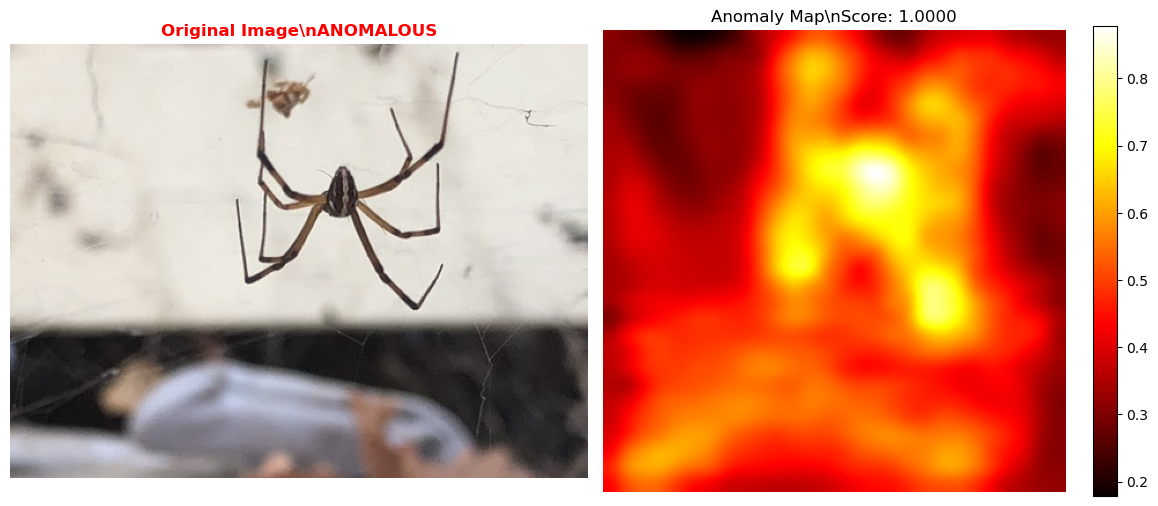

In [91]:
# EXAMPLE 1: EVALUATE SINGLE IMAGE
# Replace 'path/to/your/test/image.jpg' with your actual image path

# Example for single image evaluation
def evaluate_single_test_image(image_path: str):
    """Example function to evaluate a single test image"""
    print(f"🔍 Evaluating single image: {image_path}")
    
    # Check if file exists
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return None
    
    # Run prediction
    result = evaluator.predict_single_image(image_path)
    
    # Print results
    print(f"\\n📊 PREDICTION RESULTS:")
    print(f"   Image: {Path(image_path).name}")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Anomaly Score: {result['anomaly_score']:.6f}")
    print(f"   Threshold: {result['threshold_used']:.6f}")
    print(f"   Confidence: {result['confidence']:.6f}")
    
    # Simple visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original image
    img = Image.open(image_path).convert('RGB')
    axes[0].imshow(img)
    title_color = 'red' if result['is_anomalous'] else 'green'
    axes[0].set_title(f"Original Image\\n{result['prediction']}", color=title_color, fontweight='bold')
    axes[0].axis('off')
    
    # Anomaly map
    if result['anomaly_map'] is not None:
        im = axes[1].imshow(result['anomaly_map'], cmap='hot')
        axes[1].set_title(f"Anomaly Map\\nScore: {result['anomaly_score']:.4f}")
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1])
    else:
        axes[1].text(0.5, 0.5, 'No anomaly map available', ha='center', va='center')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return result

print("✅ Single image evaluation function ready!")
print("📝 Usage: evaluate_single_test_image('path/to/your/image.jpg')")

# Uncomment and modify the line below to test with your own image:
result = evaluate_single_test_image('/Users/zideng/Work/LDAWT/examples/black_widows_6_17/Latrodectus_hesperus/99758577.jpg')


In [66]:
# Set random seed for reproducible results
random.seed(42)

# Collect all image files first
normal_files = []
abnormal_files = []

for root, dirs, files in os.walk("/Users/zideng/Work/LDAWT/examples/black_widows_6_17"):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            full_path = os.path.join(root, file)
            if "Latrodectus_hesperus" in root:
                abnormal_files.append(full_path)
            else:
                normal_files.append(full_path)

# Randomly sample the desired number of files
normal_sample = random.sample(normal_files, min(100, len(normal_files)))
abnormal_sample = random.sample(abnormal_files, min(200, len(abnormal_files)))

# Copy the sampled files
for file_path in normal_sample:
    filename = os.path.basename(file_path)
    shutil.copy(file_path, os.path.join("spider_test/normal", filename))

for file_path in abnormal_sample:
    filename = os.path.basename(file_path)
    shutil.copy(file_path, os.path.join("spider_test/abnormal", filename))

print(f"Copied {len(normal_sample)} files to normal folder")
print(f"Copied {len(abnormal_sample)} files to abnormal folder")
    

Copied 100 files to normal folder
Copied 200 files to abnormal folder


✅ Directory evaluation function ready!
📝 Usage: evaluate_directory('/path/to/your/test/images/')
\n💡 Examples:
   results = evaluate_directory('spider_test/normal')
   results = evaluate_directory('spider_test/abnormal')
   results = evaluate_directory('/path/to/new/test/images')
🔍 Evaluating all images in directory: spider_test/abnormal
📁 Found 200 images in spider_test/abnormal
🔍 Evaluating 200 images...
  [1/200] 100465954.jpg: ANOMALOUS (score: 0.7417)
  [2/200] 104566237.jpg: ANOMALOUS (score: 0.8705)
  [3/200] 106083969.jpeg: ANOMALOUS (score: 0.9617)
  [4/200] 110048660.jpg: ANOMALOUS (score: 0.8978)
  [5/200] 11015138.jpeg: ANOMALOUS (score: 1.0000)
  [6/200] 110819332.jpg: ANOMALOUS (score: 0.7636)
  [7/200] 115339054.jpeg: NORMAL (score: 0.4038)
  [8/200] 126560838.jpg: ANOMALOUS (score: 0.7130)
  [9/200] 129237673.jpg: ANOMALOUS (score: 0.8482)
  [10/200] 129670807.jpg: ANOMALOUS (score: 0.8365)
  [11/200] 139636494.jpeg: ANOMALOUS (score: 0.8393)
  [12/200] 140832195.jpg: A

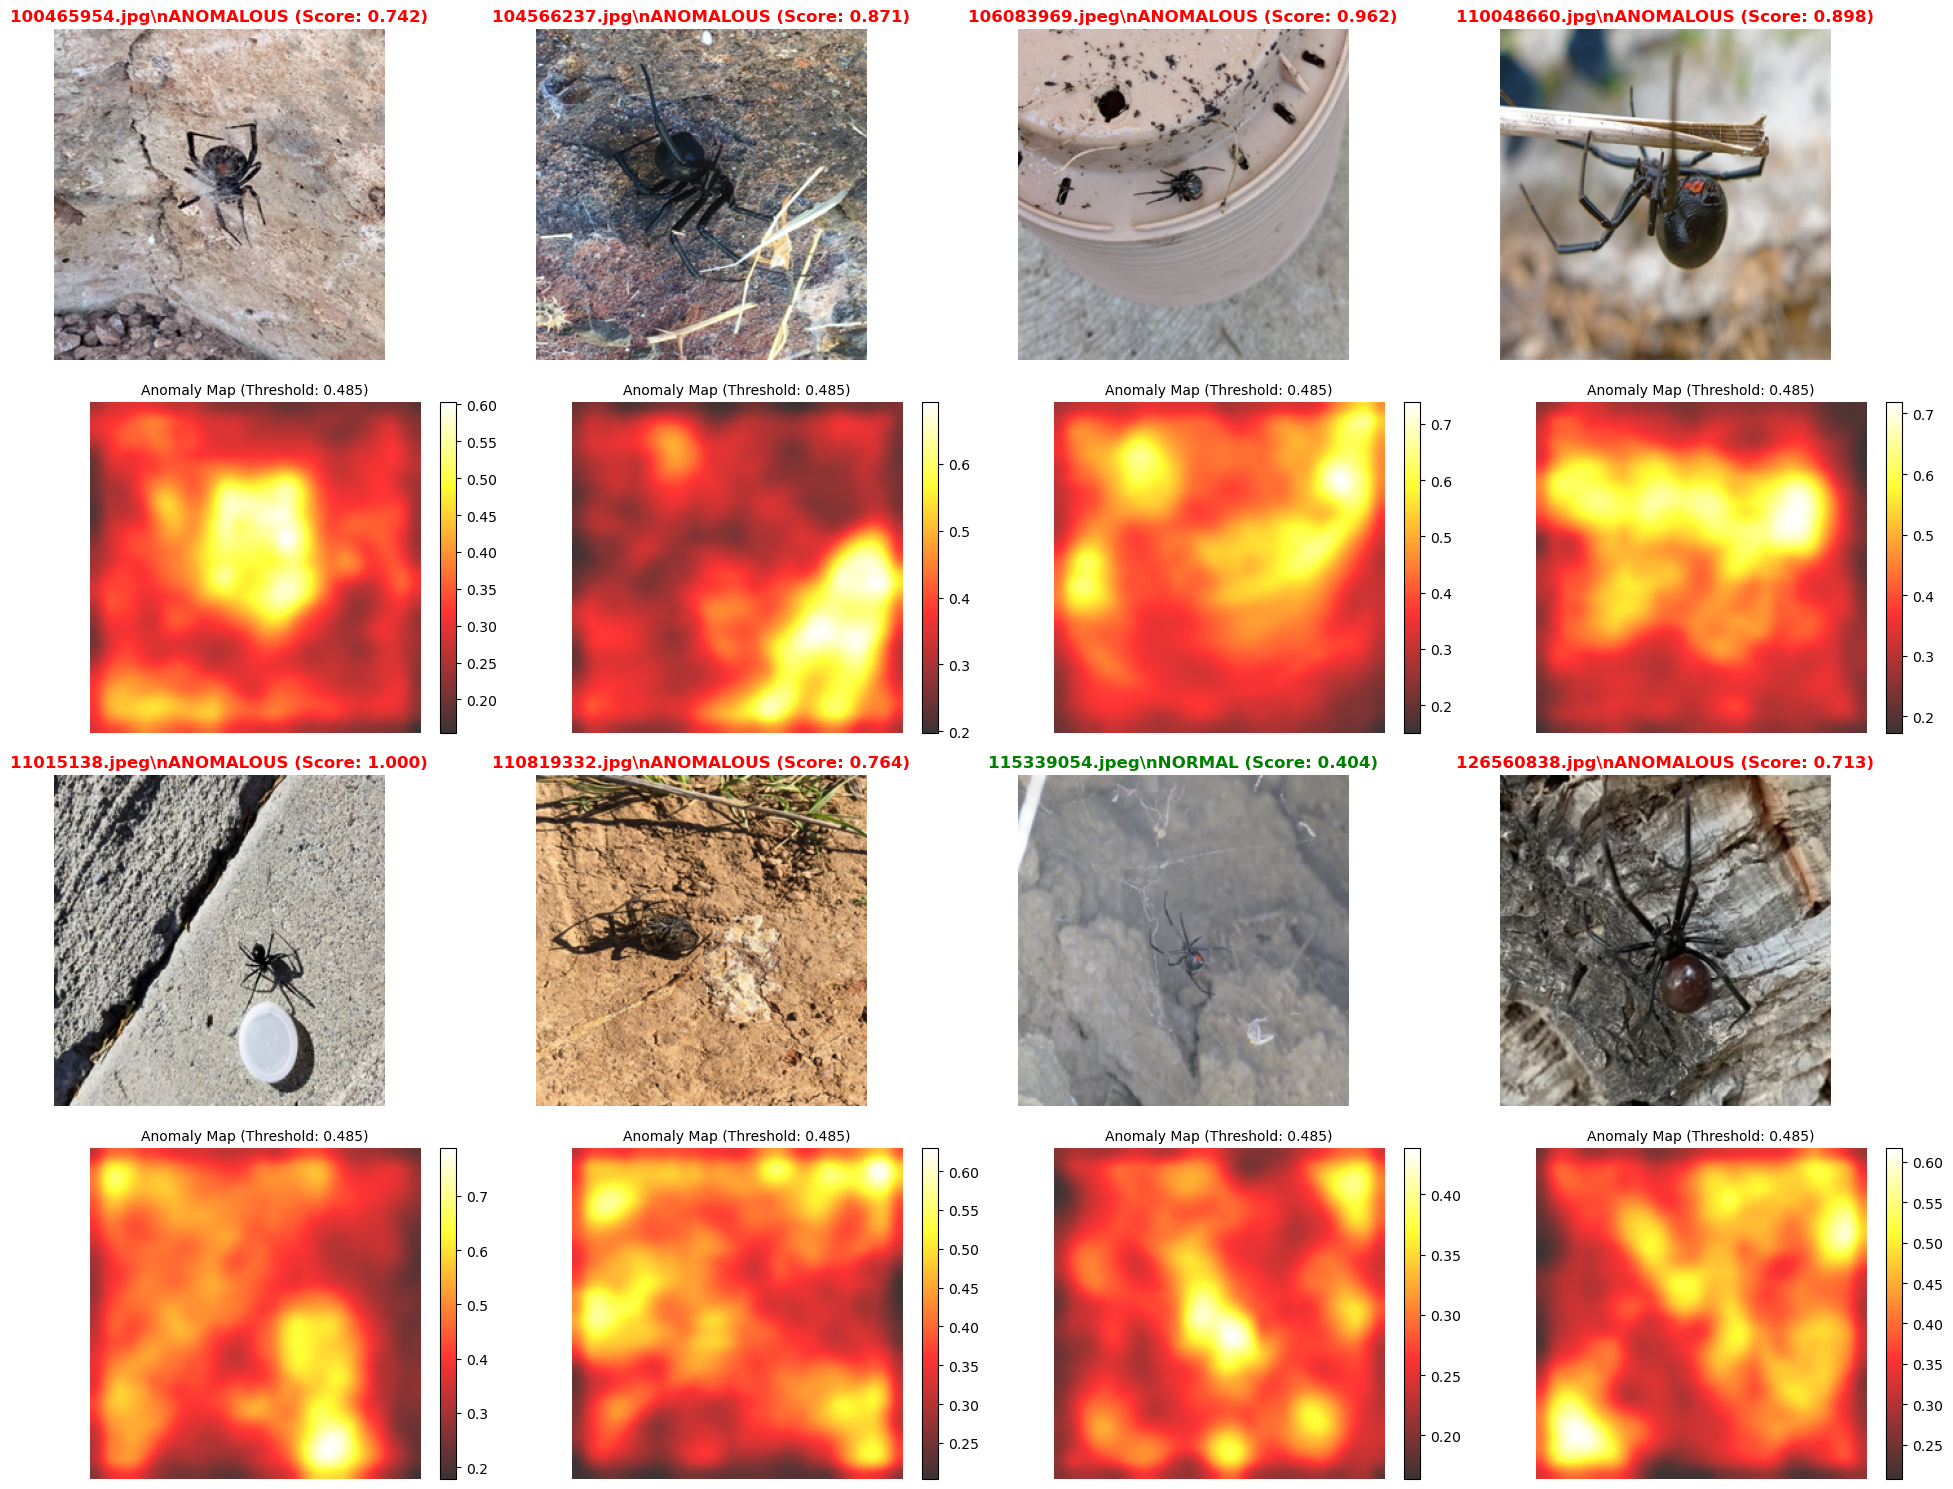

✅ Results logged to wandb


In [15]:
# EXAMPLE 2: EVALUATE BATCH OF IMAGES FROM DIRECTORY
# This example shows how to evaluate all images in a directory

def evaluate_directory(directory_path: str, max_display: int = 12):
    """
    Evaluate all images in a directory and show comprehensive results
    
    Args:
        directory_path: Path to directory containing test images
        max_display: Maximum number of images to display in visualization
    """
    print(f"🔍 Evaluating all images in directory: {directory_path}")
    
    # Collect all image paths
    image_paths = collect_test_images(directory_path)
    
    if not image_paths:
        print("❌ No images found in the specified directory")
        return None
    
    # Run batch evaluation
    results = evaluator.evaluate_batch(image_paths)
    
    if not results:
        print("❌ No successful evaluations")
        return None
    
    # Print summary report
    evaluator.print_summary_report(results)
    
    # Create visualizations
    print(f"\\n🖼️  Displaying first {min(max_display, len(results))} results...")
    evaluator.visualize_predictions(results, max_display=max_display)
    
    # Log to wandb if available
    if 'wandb' in globals() and wandb.run is not None:
        summary = evaluator.generate_summary_report(results)
        wandb.log({
            "evaluation/total_images": summary['total_images'],
            "evaluation/normal_count": summary['normal_count'],
            "evaluation/anomalous_count": summary['anomalous_count'],
            "evaluation/mean_anomaly_score": summary['mean_anomaly_score'],
            "evaluation/std_anomaly_score": summary['std_anomaly_score']
        })
        print("✅ Results logged to wandb")
    
    return results

print("✅ Directory evaluation function ready!")
print("📝 Usage: evaluate_directory('/path/to/your/test/images/')")
print("\\n💡 Examples:")
print("   results = evaluate_directory('spider_test/normal')")  # Evaluate existing normal images
print("   results = evaluate_directory('spider_test/abnormal')") # Evaluate existing abnormal images
print("   results = evaluate_directory('/path/to/new/test/images')")  # Your new test images

# Uncomment to test with your existing data:
results = evaluate_directory('spider_test/abnormal', max_display=8)
#results = evaluate_directory('spider_test/abnormal', max_display=8)


✅ Advanced evaluation function ready!
📝 Usage: results, df = evaluate_with_detailed_analysis(image_paths)
💡 This function provides:
   - Detailed statistical analysis
   - Comprehensive visualizations
   - CSV export of results
   - Top anomalous/normal image identification
📁 Found 200 images in spider_test/abnormal
🔬 Advanced evaluation of 200 images...
🔍 Evaluating 200 images...
  [1/200] 100465954.jpg: ANOMALOUS (score: 0.7417)
  [2/200] 104566237.jpg: ANOMALOUS (score: 0.8705)
  [3/200] 106083969.jpeg: ANOMALOUS (score: 0.9617)
  [4/200] 110048660.jpg: ANOMALOUS (score: 0.8978)
  [5/200] 11015138.jpeg: ANOMALOUS (score: 1.0000)
  [6/200] 110819332.jpg: ANOMALOUS (score: 0.7636)
  [7/200] 115339054.jpeg: NORMAL (score: 0.4038)
  [8/200] 126560838.jpg: ANOMALOUS (score: 0.7130)
  [9/200] 129237673.jpg: ANOMALOUS (score: 0.8482)
  [10/200] 129670807.jpg: ANOMALOUS (score: 0.8365)
  [11/200] 139636494.jpeg: ANOMALOUS (score: 0.8393)
  [12/200] 140832195.jpg: ANOMALOUS (score: 0.5937)
 

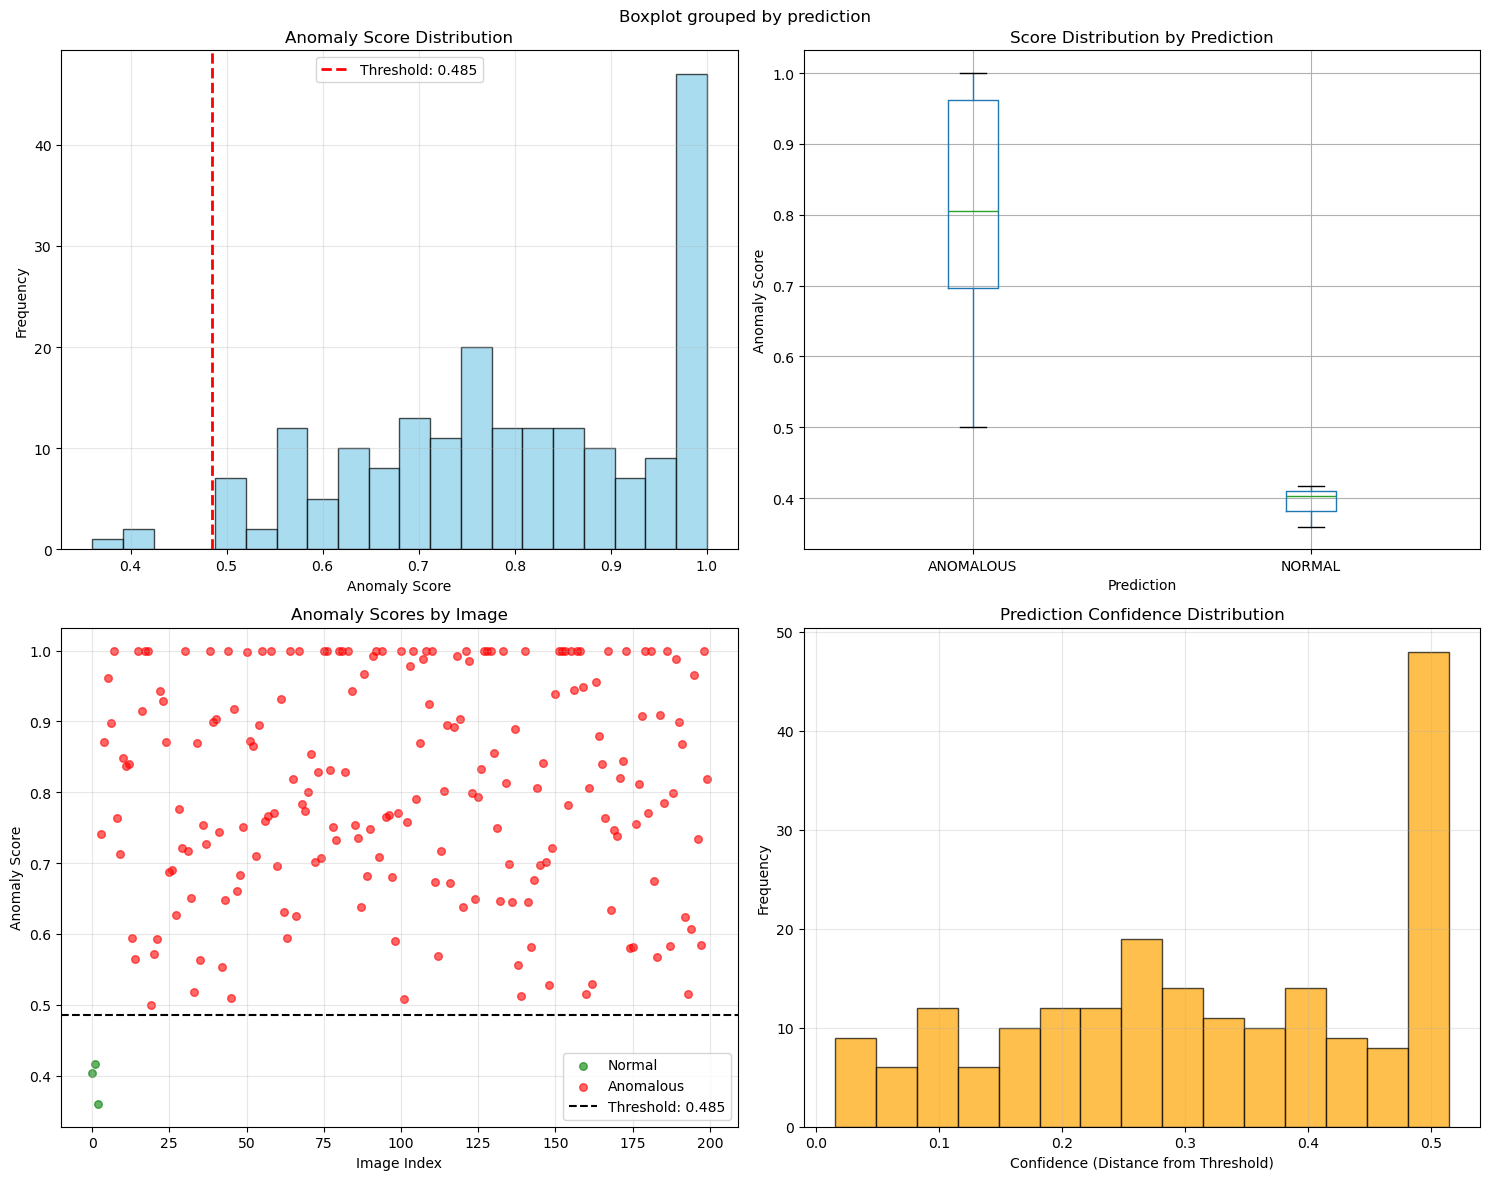

\n💾 Results saved to: anomaly_evaluation_results_20250917_112515.csv
\n🔍 TOP 5 MOST ANOMALOUS IMAGES:
   image_name  anomaly_score prediction
11015138.jpeg            1.0  ANOMALOUS
147031381.jpg            1.0  ANOMALOUS
 14779754.jpg            1.0  ANOMALOUS
150336226.jpg            1.0  ANOMALOUS
177570206.jpg            1.0  ANOMALOUS
\n✅ TOP 5 MOST NORMAL IMAGES:
    image_name  anomaly_score prediction
 410804738.jpg       0.360011     NORMAL
115339054.jpeg       0.403803     NORMAL
201661942.jpeg       0.417093     NORMAL
 152532108.jpg       0.500000  ANOMALOUS
297902198.jpeg       0.507896  ANOMALOUS


In [14]:
# EXAMPLE 3: ADVANCED EVALUATION WITH CUSTOM ANALYSIS
# This example shows advanced features and custom analysis

def evaluate_with_detailed_analysis(image_paths: List[str], save_results: bool = True):
    """
    Advanced evaluation with detailed analysis and optional result saving
    
    Args:
        image_paths: List of image paths to evaluate
        save_results: Whether to save results to CSV file
    """
    print(f"🔬 Advanced evaluation of {len(image_paths)} images...")
    
    # Run evaluation
    results = evaluator.evaluate_batch(image_paths)
    
    if not results:
        print("❌ No successful evaluations")
        return None
    
    # Create detailed analysis
    import pandas as pd
    
    # Convert results to DataFrame for analysis
    df_data = []
    for result in results:
        df_data.append({
            'image_name': Path(result['image_path']).name,
            'image_path': result['image_path'],
            'anomaly_score': result['anomaly_score'],
            'is_anomalous': result['is_anomalous'],
            'prediction': result['prediction'],
            'confidence': result['confidence'],
            'threshold_used': result['threshold_used']
        })
    
    df = pd.DataFrame(df_data)
    
    # Print detailed statistics
    print("\\n📊 DETAILED STATISTICAL ANALYSIS:")
    print("="*80)
    print(f"Dataset Summary:")
    print(f"  Total Images: {len(df)}")
    print(f"  Normal Predictions: {len(df[df['prediction'] == 'NORMAL'])}")
    print(f"  Anomalous Predictions: {len(df[df['prediction'] == 'ANOMALOUS'])}")
    
    print(f"\\nScore Statistics:")
    print(f"  Mean Score: {df['anomaly_score'].mean():.6f}")
    print(f"  Median Score: {df['anomaly_score'].median():.6f}")
    print(f"  Std Deviation: {df['anomaly_score'].std():.6f}")
    print(f"  Min Score: {df['anomaly_score'].min():.6f}")
    print(f"  Max Score: {df['anomaly_score'].max():.6f}")
    
    # Score distribution by prediction
    normal_scores = df[df['prediction'] == 'NORMAL']['anomaly_score']
    anomalous_scores = df[df['prediction'] == 'ANOMALOUS']['anomaly_score']
    
    if len(normal_scores) > 0:
        print(f"\\nNormal Images (n={len(normal_scores)}):")
        print(f"  Mean Score: {normal_scores.mean():.6f}")
        print(f"  Score Range: {normal_scores.min():.6f} - {normal_scores.max():.6f}")
    
    if len(anomalous_scores) > 0:
        print(f"\\nAnomalous Images (n={len(anomalous_scores)}):")
        print(f"  Mean Score: {anomalous_scores.mean():.6f}")
        print(f"  Score Range: {anomalous_scores.min():.6f} - {anomalous_scores.max():.6f}")
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Score distribution histogram
    axes[0,0].hist(df['anomaly_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(evaluator.threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {evaluator.threshold:.3f}')
    axes[0,0].set_xlabel('Anomaly Score')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Anomaly Score Distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Box plot by prediction
    df.boxplot(column='anomaly_score', by='prediction', ax=axes[0,1])
    axes[0,1].set_title('Score Distribution by Prediction')
    axes[0,1].set_xlabel('Prediction')
    axes[0,1].set_ylabel('Anomaly Score')
    
    # 3. Scatter plot with threshold
    normal_mask = df['prediction'] == 'NORMAL'
    anomalous_mask = df['prediction'] == 'ANOMALOUS'
    
    axes[1,0].scatter(range(len(df[normal_mask])), df[normal_mask]['anomaly_score'], 
                     c='green', alpha=0.6, label='Normal', s=30)
    axes[1,0].scatter(range(len(df[normal_mask]), len(df)), df[anomalous_mask]['anomaly_score'], 
                     c='red', alpha=0.6, label='Anomalous', s=30)
    axes[1,0].axhline(evaluator.threshold, color='black', linestyle='--', label=f'Threshold: {evaluator.threshold:.3f}')
    axes[1,0].set_xlabel('Image Index')
    axes[1,0].set_ylabel('Anomaly Score')
    axes[1,0].set_title('Anomaly Scores by Image')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Confidence distribution
    axes[1,1].hist(df['confidence'], bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1,1].set_xlabel('Confidence (Distance from Threshold)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Prediction Confidence Distribution')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save results if requested
    if save_results:
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        csv_filename = f'anomaly_evaluation_results_{timestamp}.csv'
        df.to_csv(csv_filename, index=False)
        print(f"\\n💾 Results saved to: {csv_filename}")
    
    # Show top anomalous and normal images
    print(f"\\n🔍 TOP 5 MOST ANOMALOUS IMAGES:")
    top_anomalous = df.nlargest(5, 'anomaly_score')[['image_name', 'anomaly_score', 'prediction']]
    print(top_anomalous.to_string(index=False))
    
    print(f"\\n✅ TOP 5 MOST NORMAL IMAGES:")
    top_normal = df.nsmallest(5, 'anomaly_score')[['image_name', 'anomaly_score', 'prediction']]
    print(top_normal.to_string(index=False))
    
    return results, df

print("✅ Advanced evaluation function ready!")
print("📝 Usage: results, df = evaluate_with_detailed_analysis(image_paths)")
print("💡 This function provides:")
print("   - Detailed statistical analysis")
print("   - Comprehensive visualizations")
print("   - CSV export of results")
print("   - Top anomalous/normal image identification")

#result = evaluate_with_detailed_analysis(image_paths=['/Users/zideng/Work/LDAWT/examples/black_widows_6_17/Latrodectus_hesperus/99758577.jpg'])

image_paths = collect_test_images('spider_test/abnormal')
results, df = evaluate_with_detailed_analysis(image_paths)

In [74]:
# READY TO USE - QUICK START EXAMPLES
print("🚀 QUICK START GUIDE - Copy and modify these examples:")
print("="*70)

print("\\n1️⃣  EVALUATE A SINGLE IMAGE:")
print("   result = evaluate_single_test_image('/path/to/your/image.jpg')")

print("\\n2️⃣  EVALUATE ALL IMAGES IN A DIRECTORY:")
print("   results = evaluate_directory('/path/to/your/test/images')")

print("\\n3️⃣  EVALUATE SPECIFIC LIST OF IMAGES:")
print("   image_paths = ['/path/to/img1.jpg', '/path/to/img2.jpg']")
print("   results = evaluator.evaluate_batch(image_paths)")
print("   evaluator.visualize_predictions(results)")
print("   evaluator.print_summary_report(results)")

print("\\n4️⃣  ADVANCED EVALUATION WITH ANALYSIS:")
print("   image_paths = collect_test_images('/path/to/directory')")
print("   results, df = evaluate_with_detailed_analysis(image_paths)")

print("\\n5️⃣  TEST WITH YOUR EXISTING DATA:")
print("   # Test on your current normal images")
print("   normal_results = evaluate_directory('spider_test/normal')")
print("   # Test on your current abnormal images") 
print("   abnormal_results = evaluate_directory('spider_test/abnormal')")

print("\\n" + "="*70)
print("💡 KEY INFORMATION:")
print(f"   🎯 Optimal Threshold: {optimal_threshold:.6f}")
print(f"   📊 AUROC from Training: 0.522000")
print(f"   📈 F1-Score from Training: 0.952381")
print("   🔄 Model uses same preprocessing as training (eval_tf)")
print("   📈 Scores > threshold = ANOMALOUS")
print("   📉 Scores ≤ threshold = NORMAL")

print("\\n✅ Everything is ready! Start evaluating your test images! 🕷️")


🚀 QUICK START GUIDE - Copy and modify these examples:
\n1️⃣  EVALUATE A SINGLE IMAGE:
   result = evaluate_single_test_image('/path/to/your/image.jpg')
\n2️⃣  EVALUATE ALL IMAGES IN A DIRECTORY:
   results = evaluate_directory('/path/to/your/test/images')
\n3️⃣  EVALUATE SPECIFIC LIST OF IMAGES:
   image_paths = ['/path/to/img1.jpg', '/path/to/img2.jpg']
   results = evaluator.evaluate_batch(image_paths)
   evaluator.visualize_predictions(results)
   evaluator.print_summary_report(results)
\n4️⃣  ADVANCED EVALUATION WITH ANALYSIS:
   image_paths = collect_test_images('/path/to/directory')
   results, df = evaluate_with_detailed_analysis(image_paths)
\n5️⃣  TEST WITH YOUR EXISTING DATA:
   # Test on your current normal images
   normal_results = evaluate_directory('spider_test/normal')
   # Test on your current abnormal images
   abnormal_results = evaluate_directory('spider_test/abnormal')
\n======================================================================
💡 KEY INFORMATION:
   🎯 

In [75]:
# 1. Import required modules
from anomalib.data import PredictDataset
from anomalib.engine import Engine
from anomalib.models import Patchcore

# # 2. Initialize the model and load weights
# model = Patchcore()
# engine = Engine()

# 3. Prepare test data
# You can use a single image or a folder of images
dataset = PredictDataset(
    path="spider_test/normal",
    image_size=(256, 256),
)

# 4. Get predictions
predictions = engine.predict(
    model=model,
    dataset=dataset,
)

# 5. Access the results
if predictions is not None:
    for prediction in predictions:
        image_path = prediction.image_path
        anomaly_map = prediction.anomaly_map  # Pixel-level anomaly heatmap
        pred_label = prediction.pred_label  # Image-level label (0: normal, 1: anomalous)
        pred_score = prediction.pred_score  # Image-level anomaly score

ckpt_path is not provided. Model weights will not be loaded.
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, PostProcessor, PreProcessor
/Users/zideng/mamba/envs/ml/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/100 [00:00<?, ?it/s]

NotImplementedError: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash Unknown. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.